In [1]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
import h5py
from scipy.io import savemat

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from matplotlib import colors

### Load Data

In [5]:
snapshots = 100
nx = 256
ny = 128
nz = 160

In [6]:
filename = "/Users/Alex/Desktop/MEng_Resources/2D_3D_DNS_Data/snapshots.pkl"

In [7]:
with open(filename, 'rb') as f:
    obj = pickle.load(f)
    uvw3D_field = obj

In [8]:
uvw3D_field.shape

(100, 256, 128, 160, 3)

In [9]:
# with h5py.File('2D_3D_data.h5', 'w') as hf:
#     hf.create_dataset("Original_Data",  data=uvw3D_field)

### Saving to pickle or other formats

In [ ]:
filename = 'Matlab_Vorticity_Plots/s49_pred_dt0'
data = uvw3D_field[:,:,:,159,2]

In [ ]:
data.shape

In [ ]:
# savemat(filename, mdict={'data': data})

In [ ]:
hf = h5py.File(filename, 'w')

In [ ]:
hf.create_dataset('data', data=predicted_field)

In [ ]:
hf.close()

In [ ]:
with open(filename, 'wb') as f:
    pickle.dump(predicted_field, f)

### Load Trained Model

In [419]:
model = tf.keras.models.load_model("/Users/Alex/Desktop/MEng_Resources/Project_Run_Logbook/100_dt5_Run/Test_Model")

# model = tf.keras.models.load_model("/Users/Alex/Desktop/MEng_Resources/Project_Run_Logbook/Full_100_Run/Run_2/Test_Model")

# model = tf.keras.models.load_model("/Users/Alex/Desktop/MEng_Resources/Project_Run_Logbook/Full_25_Run/Test_Model")


In [417]:
# Linear interpolation test
interp_file = "/Users/Alex/Desktop/MEng_Resources/Project_Run_Logbook/linear_int_dt5.pkl"

with open(interp_file, 'rb') as f:
    obj = pickle.load(f)
    predicted_field = obj

### Prepare Prediction Input

In [420]:
# Define empty 2D dataset of 5 sections to predict 3D field
snapshot = 49
dt = 5 # in snapshots
n_slices = 5
test_sections = np.empty([nx, ny, 3*n_slices])

slice_pos = np.zeros(n_slices)
slice_distance = 0.8/ (n_slices - 1)
for i in range(n_slices):
    slice_pos[i] = (nz - 1) * (0.5 + slice_distance * (i - (n_slices - 1) / 2))
slice_pos = slice_pos.astype(int)

In [421]:
slice_pos.shape

(5,)

In [422]:
if n_slices == 3:
    test_sections[:, :, 0:3] = uvw3D_field[snapshot - dt, :, :, slice_pos[0], :]
    test_sections[:, :, 3:6] = uvw3D_field[snapshot, :, :, slice_pos[1], :]
    test_sections[:, :, 6:] = uvw3D_field[snapshot + dt, :, :, slice_pos[2], :]
elif n_slices == 5:
    test_sections[:, :, 0:3] = uvw3D_field[snapshot - 2*dt, :, :, slice_pos[0], :]
    test_sections[:, :, 3:6] = uvw3D_field[snapshot - dt, :, :, slice_pos[1], :]
    test_sections[:, :, 6:9] = uvw3D_field[snapshot, :, :, slice_pos[2], :]
    test_sections[:, :, 9:12] = uvw3D_field[snapshot + dt, :, :, slice_pos[3], :]
    test_sections[:, :, 12:] = uvw3D_field[snapshot + 2*dt, :, :, slice_pos[4], :]
elif n_slices ==7:
    test_sections[:, :, 0:3] = uvw3D_field[snapshot - 3*dt, :, :, slice_pos[0], :]
    test_sections[:, :, 3:6] = uvw3D_field[snapshot - 2*dt, :, :, slice_pos[1], :]
    test_sections[:, :, 6:9] = uvw3D_field[snapshot - dt, :, :, slice_pos[2], :]
    test_sections[:, :, 9:12] = uvw3D_field[snapshot, :, :, slice_pos[3], :]
    test_sections[:, :, 12:15] = uvw3D_field[snapshot + dt, :, :, slice_pos[4], :]
    test_sections[:, :, 15:18] = uvw3D_field[snapshot + 2*dt, :, :, slice_pos[5], :]
    test_sections[:, :, 18:] = uvw3D_field[snapshot + 3*dt, :, :, slice_pos[6], :]

In [423]:
test_sections.shape

(256, 128, 15)

In [424]:
test_sections = np.expand_dims(test_sections, axis=0)

In [425]:
test_sections.shape

(1, 256, 128, 15)

### Make Prediction

In [426]:
predicted_field = model.predict(test_sections, batch_size=1)

In [427]:
predicted_field.shape

(1, 256, 128, 160, 3)

In [428]:
predicted_field = np.squeeze(predicted_field, axis=0)

In [429]:
predicted_field.shape

(256, 128, 160, 3)

### Accuracy of Prediction

In [430]:
true_field = uvw3D_field[snapshot,:,:,:,:]

In [431]:
true_field.shape

(256, 128, 160, 3)

In [432]:
true_field_zero_mean = np.zeros(true_field.shape)
#Subtract mean from each component
true_field_zero_mean[:,:,:,0] = true_field[:,:,:,0] - np.mean(true_field[:,:,:,0])
true_field_zero_mean[:,:,:,1] = true_field[:,:,:,1] - np.mean(true_field[:,:,:,1])
true_field_zero_mean[:,:,:,2] = true_field[:,:,:,2] - np.mean(true_field[:,:,:,2])

In [433]:
pred_flat = np.ravel(predicted_field)
true_flat = np.ravel(true_field)
true_flat_zero_mean = np.ravel(true_field_zero_mean)
error = true_flat - pred_flat

In [434]:
L2 = np.linalg.norm(error) / np.linalg.norm(true_flat_zero_mean)
# L2 = np.linalg.norm(error) / np.linalg.norm(true_flat)

In [435]:
L2

0.32251692082039174

### Calculate Velocity Components & Vorticity

In [176]:
u_pred = predicted_field[:,:,:,0]
v_pred = predicted_field[:,:,:,1]
w_pred = predicted_field[:,:,:,2]

u_true = uvw3D_field[snapshot,:,:,:,0]
v_true = uvw3D_field[snapshot,:,:,:,1]
w_true = uvw3D_field[snapshot,:,:,:,2]

In [28]:
z_plane = 83

In [29]:
u_true_plot = np.ma.array(u_true)
u_true_plot[28:49, 45:82] = np.ma.masked

v_true_plot = np.ma.array(v_true)
v_true_plot[28:49, 45:82] = np.ma.masked

w_true_plot = np.ma.array(w_true)
w_true_plot[28:49, 45:82] = np.ma.masked

u_pred_plot = np.ma.array(u_pred)
u_pred_plot[28:49, 45:82] = np.ma.masked

v_pred_plot = np.ma.array(v_pred)
v_pred_plot[28:49, 45:82] = np.ma.masked

w_pred_plot = np.ma.array(w_pred)
w_pred_plot[28:49, 45:82] = np.ma.masked

In [30]:
u_pred.shape

(256, 128, 160)

In [31]:
# u_colour = matplotlib.colors.Normalize(-0.5,2.00)
# v_colour = matplotlib.colors.Normalize(-1.0,1)
# w_colour = matplotlib.colors.Normalize(-0.30,0.30)

u_colour = colors.TwoSlopeNorm(vmin=-0.5, vcenter=0.75, vmax=2)
v_colour = colors.TwoSlopeNorm(vmin=-1.2, vcenter=0, vmax=1)
w_colour = colors.TwoSlopeNorm(vmin=-0.3, vcenter=0, vmax=0.3)

In [32]:
x = np.linspace(0,16,256)
y = np.linspace(-2,2,128)
z = np.linspace(0,4,160)

X,Y = np.meshgrid(x,y,indexing='ij')

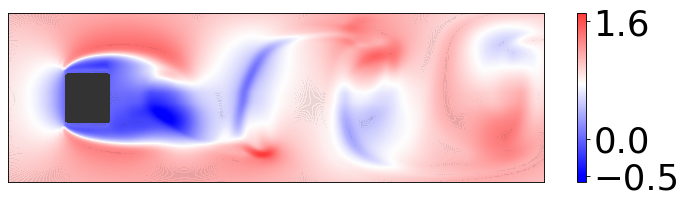

In [33]:
fig = plt.figure(figsize=(6*1.8, 1.4*2), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(X,Y,u_true_plot[:,:,z_plane],levels=500, alpha=0.9, cmap='bwr', norm=u_colour)
cb = plt.colorbar(ticks = [-0.5, 0.00, 1.6])
cb.ax.tick_params(labelsize=32)

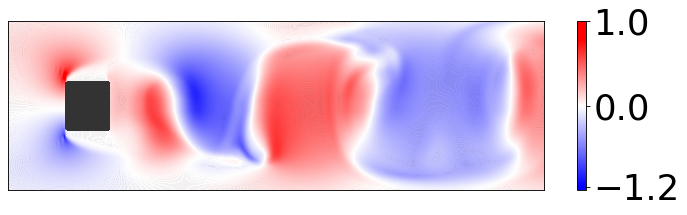

In [34]:
fig = plt.figure(figsize=(6*1.8, 1.4*2), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(X,Y,v_true_plot[:,:,z_plane],levels=500, alpha=0.95, cmap='bwr', norm=v_colour)
cb = plt.colorbar(ticks = [-1.2,0.0,1.0,2.25])
cb.ax.tick_params(labelsize=32)

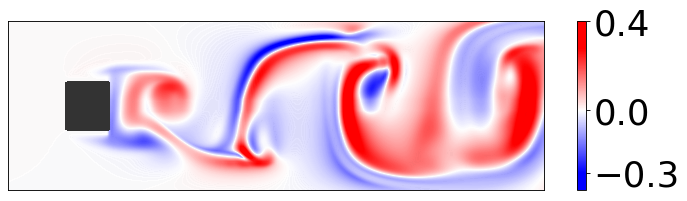

In [35]:
fig = plt.figure(figsize=(6*1.8, 1.4*2), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(X,Y,w_true_plot[:,:,z_plane],levels=500, alpha=0.98, cmap='bwr', norm = w_colour)
cb = plt.colorbar(ticks = [-0.3, 0.0, 0.4])
cb.ax.tick_params(labelsize=32)

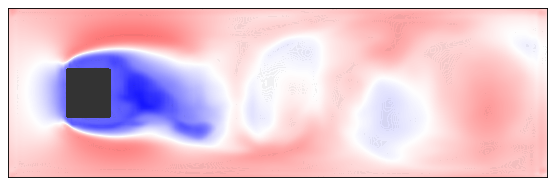

In [87]:
fig = plt.figure(figsize=(6*1.45, 1.4*2), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(X,Y,u_pred_plot[:,:,z_plane],levels=500, alpha=0.95, cmap='bwr', norm=u_colour)

In [88]:
L2_u = np.linalg.norm(u_true_plot[:,:,z_plane]- u_pred_plot[:,:,z_plane]) / np.linalg.norm(u_true_plot[:,:,z_plane] - np.mean(u_true_plot[:,:,z_plane]))
L2_u

0.4403305081475008

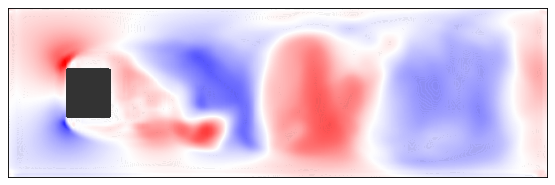

In [89]:
fig = plt.figure(figsize=(6*1.45, 1.4*2), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(X,Y,v_pred_plot[:,:,z_plane],levels=500, alpha=0.95, cmap='bwr', norm=v_colour)

In [90]:
L2_v = np.linalg.norm(v_pred_plot[:,:,z_plane]- v_true_plot[:,:,z_plane]) / np.linalg.norm(v_true_plot[:,:,z_plane]-np.mean(v_true_plot[:,:,z_plane]))
L2_v

0.4816615788595136

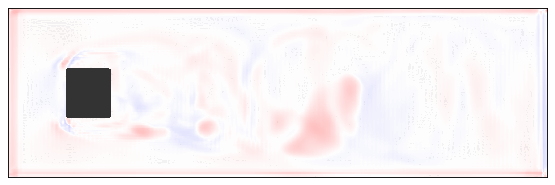

In [91]:
fig = plt.figure(figsize=(6*1.45, 1.4*2), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(X,Y,w_pred_plot[:,:,z_plane],levels=500, alpha=0.95, cmap='bwr', norm = w_colour)

In [92]:
L2_w = np.linalg.norm(w_pred_plot[:,:,z_plane]- w_true_plot[:,:,z_plane]) / np.linalg.norm(w_true_plot[:,:,z_plane]-np.mean(w_true_plot[:,:,z_plane]))
L2_w

1.0252929146763572

In [93]:
def vorticity(u,v,w):
    
    dudx = np.empty(u.shape)
    dudy = np.empty(u.shape)
    dudz = np.empty(u.shape)

    dvdx = np.empty(v.shape)
    dvdy = np.empty(v.shape)
    dvdz = np.empty(v.shape)

    dwdx = np.empty(w.shape)
    dwdy = np.empty(w.shape)
    dwdz = np.empty(w.shape)
    
    dudx, dudy, dudz = np.gradient(u)
    dvdx, dvdy, dvdz = np.gradient(v)
    dwdx, dwdy, dwdz = np.gradient(w)
    
    omegax = dwdy-dvdz
    omegay = dudz-dwdx
    omegaz = dvdx-dudy
    
    return omegax, omegay, omegaz

In [94]:
omegax_pred, omegay_pred, omegaz_pred = vorticity(u_pred, v_pred, w_pred)

In [95]:
omegax_true, omegay_true, omegaz_true = vorticity(u_true, v_true, w_true)

In [96]:
# omega_pred = np.power(omegax_pred[:,:,z_plane]**2 + omegay_pred[:,:,z_plane]**2 + omegaz_pred[:,:,z_plane]**2,0.5)
# omega_true = np.power(omegax_true[:,:,z_plane]**2 + omegay_true[:,:,z_plane]**2 + omegaz_true[:,:,z_plane]**2,0.5)

omega_pred = np.abs(omegaz_pred[:,:,z_plane])
omega_true = np.abs(omegaz_true[:,:,z_plane])


In [97]:
# with h5py.File('omega_true_plane.h5', 'w') as hf:
#     hf.create_dataset("Vorticity_Plane_test",  data=omega_true)

In [98]:
omega_pred_plot = np.ma.array(omega_pred)
omega_pred_plot[28:49, 45:82] = np.ma.masked

omega_true_plot = np.ma.array(omega_true)
omega_true_plot[28:49, 45:82] = np.ma.masked

In [99]:
normalise_error = matplotlib.colors.Normalize(0.0,0.4)

In [100]:
# tol = 1e-3

# zero_flag = omega_pred_plot < tol
# omega_pred_plot[zero_flag] = 0
# omega_true_plot[zero_flag] = 0

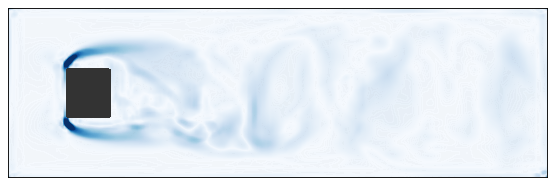

In [101]:
fig = plt.figure(figsize=(6*1.45, 1.4*2), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(X,Y,omega_pred_plot,levels=500, alpha=0.98, cmap='Blues', norm=normalise_error)

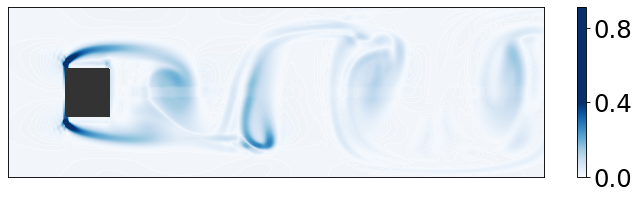

In [102]:
fig = plt.figure(figsize=(6*1.8, 1.4*2), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(X,Y,omega_true_plot,levels=500, alpha=0.98, cmap='Blues', norm=normalise_error)
cb = plt.colorbar(ticks = [0.0, 0.4, 0.8])
cb.ax.tick_params(labelsize=22)

In [103]:
vorticity_error = abs(omega_true_plot - omega_pred_plot)

In [104]:
L2_vort = np.linalg.norm(omega_pred_plot- omega_true_plot) / np.linalg.norm(omega_true_plot - np.mean(omega_true_plot))
L2_vort

0.6303985552567595

In [64]:
omega_true_plot.min()

2.8181515612171e-07

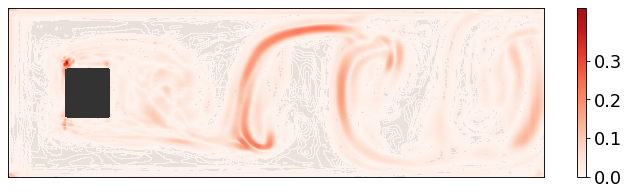

In [65]:
fig = plt.figure(figsize=(6*1.8, 1.4*2), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(X,Y,vorticity_error,levels=500, alpha=0.9, cmap='Reds', norm=normalise_error)
cb = plt.colorbar(ticks = [0.00, 0.10, 0.20, 0.30, 0.80])
cb.ax.tick_params(labelsize=16)

### Variation of Error with z/D

In [33]:
predicted_field.shape

(256, 128, 160, 3)

In [34]:
np.ravel(predicted_field[:,:,3]).shape[0] == 256 * 128 * 3

True

In [50]:
L2_z = np.zeros(nz)

for i in range(nz):
    flat_pred = np.ravel(predicted_field[:,:,i])
    flat_true = np.ravel(true_field[:,:,i])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[:,:,i])
    error_z = flat_true - flat_pred
    
    L2_z[i] = np.linalg.norm(error_z) / np.linalg.norm(flat_true_zero_mean)

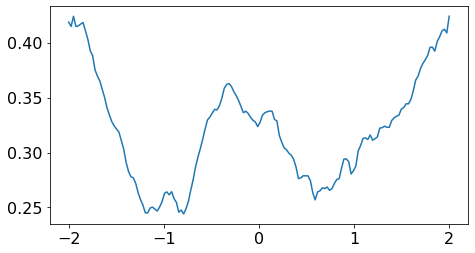

In [51]:
x = np.linspace(-2, 2, nz)

plt.figure(figsize=(7.5, 4))
plt.plot(x, L2_z, label='dataset size')
plt.tick_params(labelsize=16)

In [26]:
np.mean(L2_z)

0.09768295326401263

### Plot for different dataset sizes, slice number or dt training - Run separately

In [208]:
L2_100 = np.zeros(nz)

for i in range(nz):
    flat_pred = np.ravel(predicted_field[:,:,i])
    flat_true = np.ravel(true_field[:,:,i])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[:,:,i])
    error_z = flat_true - flat_pred
    
    L2_100[i] = np.linalg.norm(error_z) / np.linalg.norm(flat_true_zero_mean)

In [280]:
L2_75 = np.zeros(nz)

for i in range(nz):
    flat_pred = np.ravel(predicted_field[:,:,i])
    flat_true = np.ravel(true_field[:,:,i])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[:,:,i])
    error_z = flat_true - flat_pred
    L2_75[i] = np.linalg.norm(error_z) / np.linalg.norm(flat_true_zero_mean)

In [298]:
L2_50 = np.zeros(nz)

for i in range(nz):
    flat_pred = np.ravel(predicted_field[:,:,i])
    flat_true = np.ravel(true_field[:,:,i])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[:,:,i])
    error_z = flat_true - flat_pred
    L2_50[i] = np.linalg.norm(error_z) / np.linalg.norm(flat_true_zero_mean)

In [316]:
L2_25 = np.zeros(nz)

for i in range(nz):
    flat_pred = np.ravel(predicted_field[:,:,i])
    flat_true = np.ravel(true_field[:,:,i])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[:,:,i])
    error_z = flat_true - flat_pred
    L2_25[i] = np.linalg.norm(error_z) / np.linalg.norm(flat_true_zero_mean)
    


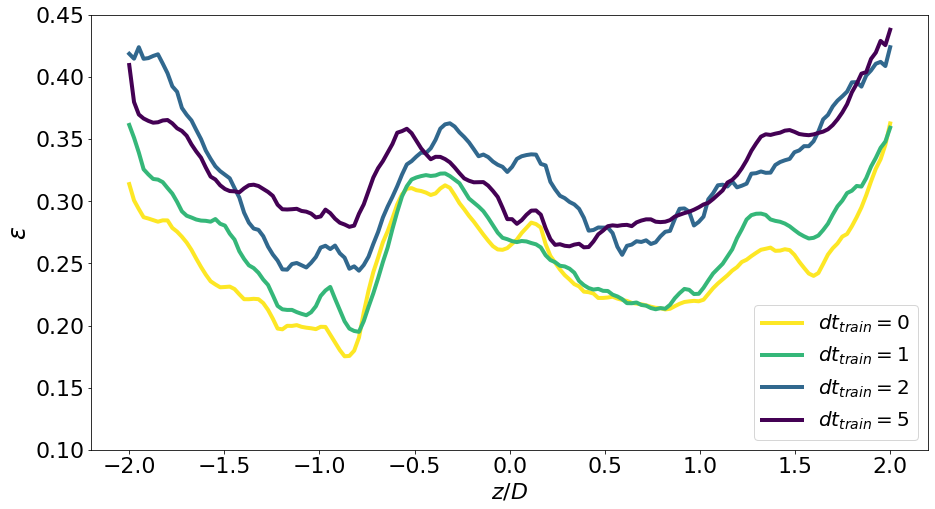

In [319]:
x = np.linspace(-2, 2, nz)

plt.figure(figsize=(15, 8))
plt.plot(x, L2_100, color='#fde725', linewidth=4, label='$dt_{train} = 0$')
plt.plot(x, L2_75, color='#35b779', linewidth=4, label='$dt_{train} = 1$')
plt.plot(x, L2_50, color='#31688e', linewidth=4, label='$dt_{train} = 2$')
plt.plot(x, L2_25, color='#440154', linewidth=4, label='$dt_{train} = 5$')
plt.xlabel('$z/D$', size=22)
plt.ylabel('$\epsilon$', size=24)
plt.ylim(0.1,0.45)

# plt.title("Performance of Time-Informed Network vs Linear Interpolation; $dt = 0$", fontsize=18)
plt.legend(loc='best', prop={'size': 20})
plt.tick_params(labelsize=22)

### dt Sweep for all models

In [320]:
time_delta = np.arange(21)
dt_errors_1 = []
dt_errors_2 = []
dt_errors_3 = []
dt_errors_4 = []

In [327]:
for dt in time_delta:
    # Define empty 2D dataset of 5 sections to predict 3D field
    test_sections = np.empty([nx, ny, 15])
    snapshot = 49

    slice_pos = np.array([(nz - 1) * 0.1, (nz - 1) * 0.3, (nz - 1) * 0.5, (nz - 1) * 0.7, (nz - 1) * 0.9])
    slice_pos = slice_pos.astype(int)
    
    test_sections[:, :, 0:3] = uvw3D_field[snapshot - 2*dt, :, :, slice_pos[0], :]
    test_sections[:, :, 3:6] = uvw3D_field[snapshot - dt, :, :, slice_pos[1], :]
    test_sections[:, :, 6:9] = uvw3D_field[snapshot, :, :, slice_pos[2], :]
    test_sections[:, :, 9:12] = uvw3D_field[snapshot + dt, :, :, slice_pos[3], :]
    test_sections[:, :, 12:] = uvw3D_field[snapshot + 2*dt, :, :, slice_pos[4], :]
    
    test_sections = np.expand_dims(test_sections, axis=0)
    
    predicted_field = model.predict(test_sections, batch_size=1)
    predicted_field = np.squeeze(predicted_field, axis=0)
    
    true_field = uvw3D_field[snapshot,:,:,:,:]
    
    true_field_zero_mean = np.zeros(true_field.shape)
    #Subtract mean from each component
    true_field_zero_mean[:,:,:,0] = true_field[:,:,:,0] - np.mean(true_field[:,:,:,0])
    true_field_zero_mean[:,:,:,1] = true_field[:,:,:,1] - np.mean(true_field[:,:,:,1])
    true_field_zero_mean[:,:,:,2] = true_field[:,:,:,2] - np.mean(true_field[:,:,:,2])
    
    pred_flat = np.ravel(predicted_field)
    true_flat = np.ravel(true_field)
    flat_true_zero_mean = np.ravel(true_field_zero_mean)
    error = true_flat - pred_flat
    
    dt_errors_1.append(np.linalg.norm(error) / np.linalg.norm(flat_true_zero_mean))
    

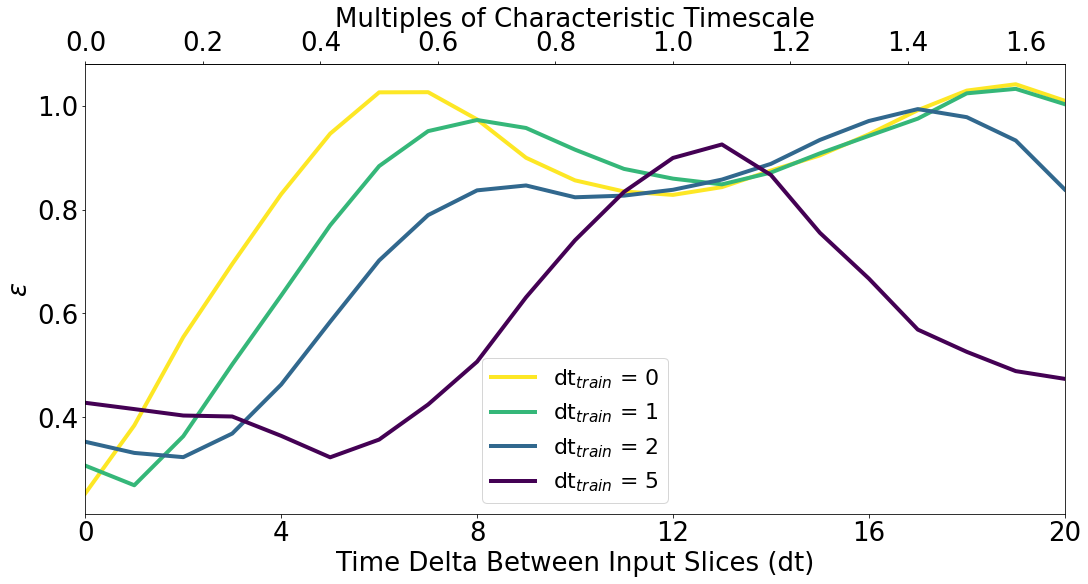

In [333]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(15, 8)
ax.plot(time_delta, dt_errors_1, color='#fde725', linewidth=4, label='dt$_{train}$ = 0')
ax.plot(time_delta, dt_errors_2, color='#35b779', linewidth=4, label='dt$_{train}$ = 1')
ax.plot(time_delta, dt_errors_3, color='#31688e', linewidth=4, label='dt$_{train}$ = 2')
ax.plot(time_delta, dt_errors_4, color='#440154', linewidth=4, label='dt$_{train}$ = 5')
ax.set_xlabel("Time Delta Between Input Slices (dt)", fontsize=26)
ax.set_ylabel("$\epsilon$", fontsize=26)
#ax.set_title("Reconstruction for Different Time Delta Between Snapshots", fontsize=18)
ax.tick_params(labelsize=26)
ax.set_xticks([0,4,8,12,16,20])
plt.xlim(0,20)
plt.legend(loc='best', prop={'size': 22})


def forward(x):
    return 2 * x / 24


def inverse(x):
    return 24 * x / 2

secax = ax.secondary_xaxis('top', functions=(forward, inverse))
secax.set_xlabel('Multiples of Characteristic Timescale', fontsize=26)
secax.tick_params(labelsize=26)
plt.show()

### Delta Between CNN and Linear Interpolation at Different dt

In [335]:
L2_dt0_lin = np.zeros(nz)

for i in range(nz):
    flat_pred = np.ravel(predicted_field[:,:,i])
    flat_true = np.ravel(true_field[:,:,i])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[:,:,i])
    error_z = flat_true - flat_pred
    L2_dt0_lin[i] = np.linalg.norm(error_z) / np.linalg.norm(flat_true_zero_mean)

In [375]:
L2_dt0 = np.zeros(nz)

for i in range(nz):
    flat_pred = np.ravel(predicted_field[:,:,i])
    flat_true = np.ravel(true_field[:,:,i])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[:,:,i])
    error_z = flat_true - flat_pred
    L2_dt0[i] = np.linalg.norm(error_z) / np.linalg.norm(flat_true_zero_mean)

In [376]:
e_dt0 = L2_dt0_lin - L2_dt0

In [356]:
L2_dt1_lin = np.zeros(nz)

for i in range(nz):
    flat_pred = np.ravel(predicted_field[:,:,i])
    flat_true = np.ravel(true_field[:,:,i])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[:,:,i])
    error_z = flat_true - flat_pred
    L2_dt1_lin[i] = np.linalg.norm(error_z) / np.linalg.norm(flat_true_zero_mean)

In [394]:
L2_dt1 = np.zeros(nz)

for i in range(nz):
    flat_pred = np.ravel(predicted_field[:,:,i])
    flat_true = np.ravel(true_field[:,:,i])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[:,:,i])
    error_z = flat_true - flat_pred
    L2_dt1[i] = np.linalg.norm(error_z) / np.linalg.norm(flat_true_zero_mean)

In [395]:
e_dt1 = L2_dt1_lin - L2_dt1

In [397]:
L2_dt2_lin = np.zeros(nz)

for i in range(nz):
    flat_pred = np.ravel(predicted_field[:,:,i])
    flat_true = np.ravel(true_field[:,:,i])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[:,:,i])
    error_z = flat_true - flat_pred
    L2_dt2_lin[i] = np.linalg.norm(error_z) / np.linalg.norm(flat_true_zero_mean)

In [415]:
L2_dt2 = np.zeros(nz)

for i in range(nz):
    flat_pred = np.ravel(predicted_field[:,:,i])
    flat_true = np.ravel(true_field[:,:,i])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[:,:,i])
    error_z = flat_true - flat_pred
    L2_dt2[i] = np.linalg.norm(error_z) / np.linalg.norm(flat_true_zero_mean)

In [416]:
e_dt2 = L2_dt2_lin - L2_dt2

In [418]:
L2_dt5_lin = np.zeros(nz)

for i in range(nz):
    flat_pred = np.ravel(predicted_field[:,:,i])
    flat_true = np.ravel(true_field[:,:,i])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[:,:,i])
    error_z = flat_true - flat_pred
    L2_dt5_lin[i] = np.linalg.norm(error_z) / np.linalg.norm(flat_true_zero_mean)

In [436]:
L2_dt5 = np.zeros(nz)

for i in range(nz):
    flat_pred = np.ravel(predicted_field[:,:,i])
    flat_true = np.ravel(true_field[:,:,i])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[:,:,i])
    error_z = flat_true - flat_pred
    L2_dt5[i] = np.linalg.norm(error_z) / np.linalg.norm(flat_true_zero_mean)

In [437]:
e_dt5 = L2_dt5_lin - L2_dt5

In [98]:
L2_dt6_lin = np.zeros(nz)

for i in range(nz):
    flat_pred = np.ravel(predicted_field[:,:,i])
    flat_true = np.ravel(true_field[:,:,i])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[:,:,i])
    error_z = flat_true - flat_pred
    L2_dt6_lin[i] = np.linalg.norm(error_z) / np.linalg.norm(flat_true_zero_mean)

In [109]:
L2_dt6 = np.zeros(nz)

for i in range(nz):
    flat_pred = np.ravel(predicted_field[:,:,i])
    flat_true = np.ravel(true_field[:,:,i])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[:,:,i])
    error_z = flat_true - flat_pred
    L2_dt6[i] = np.linalg.norm(error_z) / np.linalg.norm(flat_true_zero_mean)

In [110]:
e_dt6 = L2_dt6_lin - L2_dt6

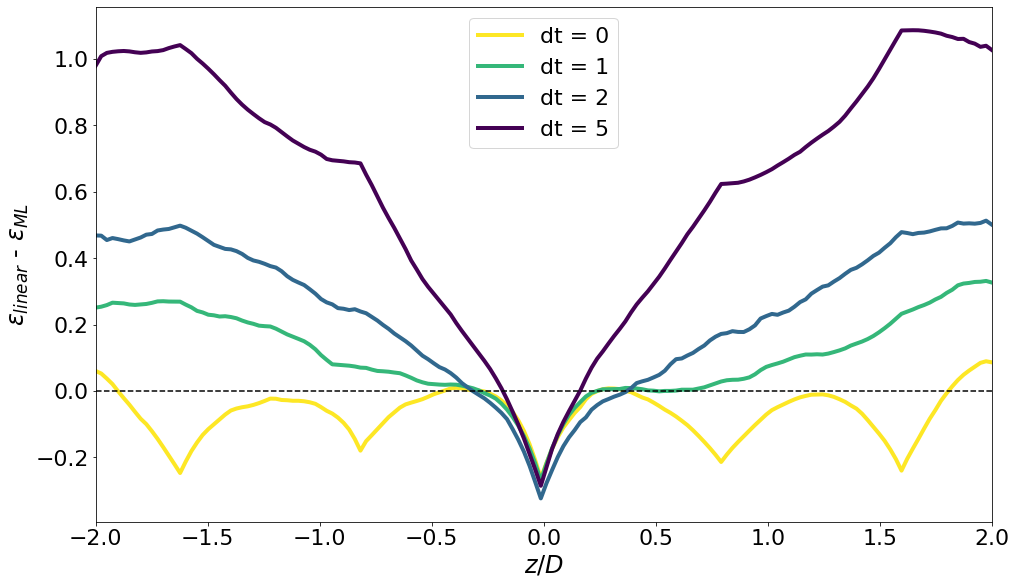

In [438]:
z = np.linspace(-2, 2, nz)

fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(14, 8)
ax.plot(z, e_dt0, color='#fde725', linewidth=4, label='dt = 0')
ax.plot(z, e_dt1, color='#35b779', linewidth=4, label='dt = 1')
ax.plot(z, e_dt2, color='#31688e', linewidth=4, label='dt = 2')
ax.plot(z, e_dt5, color='#440154', linewidth=4, label='dt = 5')
# ax.plot(z, e_dt6, 'y', linewidth=4, label='dt = 6')
ax.plot(z, np.zeros(z.shape), 'k--')
ax.set_xlabel("$z/D$", fontsize=24)
ax.set_ylabel("$\epsilon_{linear}$ - $\epsilon_{ML}$", fontsize=24)
#ax.set_title("Reconstruction for Different Time Delta Between Snapshots", fontsize=18)
ax.tick_params(labelsize=22)
plt.xlim(-2,2)
plt.legend(loc='best', prop={'size': 22})

### Log training time plots

In [146]:
data_size = [25,50,75,100]
x = np.linspace(25,100)
training_time = [45, 68, 81, 106]
log_time = np.log(training_time)
epochs = [4060, 3130, 2710, 2630] / np.mean(training_time)

In [147]:
m, b = np.polyfit(data_size, training_time, 1)

In [148]:
b

25.99999999999998

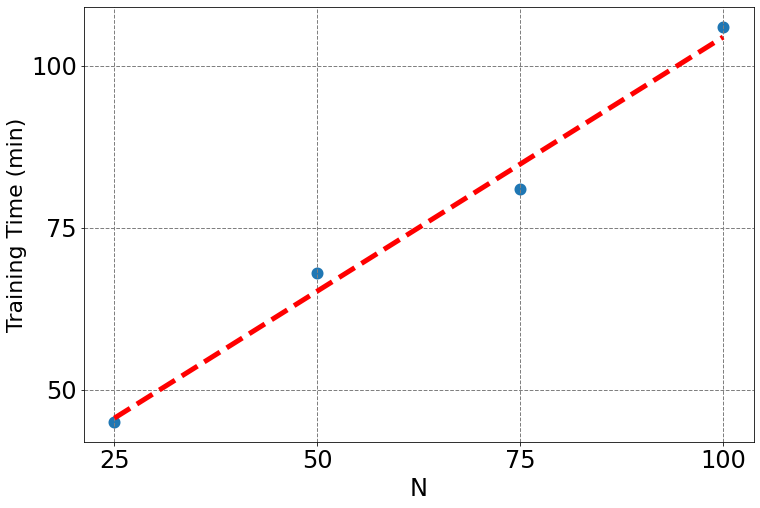

In [158]:
plt.figure(figsize=(12, 8))
plt.scatter(data_size, training_time, linewidth=6)
plt.plot(x, m*x + b, 'r--', linewidth=5)
# plt.plot(data_size, epochs)
plt.xlabel('N', size=24)
plt.ylabel('Training Time (min)', size=22)
plt.xticks([25,50,75,100])
plt.yticks([50,75,100])
plt.tick_params(labelsize=24)
plt.grid(color = 'grey', linestyle = '--', linewidth = 1)

### 4D Limitation Using PIV-like time series of PLANES

In [99]:
# Construct dataset similar to scanning PIV single pass
 
single_scan = np.zeros((100,256,128,3))
slices_z = np.linspace(0,159,100)
slices_z = slices_z.astype(int)

In [101]:
for i in range(100):
    single_scan[i] = uvw3D_field[i,:,:,slices_z[i],:]

In [103]:
single_scan.shape

(100, 256, 128, 3)

In [106]:
# Build planes for single prediction
pred_4D = np.zeros((256,128,15))

pred_4D[:,:,0:3] = single_scan[0,:,:,:]
pred_4D[:,:,3:6] = single_scan[1,:,:,:]
pred_4D[:,:,6:9] = single_scan[3,:,:,:]
pred_4D[:,:,9:12] = single_scan[4,:,:,:]
pred_4D[:,:,12:] = single_scan[5,:,:,:]


In [112]:
pred_4D = np.expand_dims(pred_4D, axis=0)

In [114]:
predicted_field = model.predict(pred_4D, batch_size=1)

In [132]:
predicted_field = np.squeeze(predicted_field, axis=0)

In [139]:
predicted_field.shape

(256, 128, 160, 3)